In [1]:
import networkx as nx
import numpy as np
import copy
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random
#random.seed()
import nbconvert

In [2]:
# this function is copied from PS7 CSCI 3352 by Aaron Clauset

def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        node_colors.append(colors[int(cid)])
    nsize  = 1000
    flabel = True
    
    mapping = {i:  str(nx.get_node_attributes(G, 'population')[i]) + ' ' + str(i) for i in G.nodes()}
    #print(mapping)
    H = nx.relabel_nodes(G, mapping, copy=True)

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    plt.figure(figsize = (10, 7))
    nx.draw_circular(H,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
# This function is modified from CSCI 3352 PS9 by Aaron Clauset

def drawG_weights(G, node_colors):
    plt.figure(figsize=(10, 7))
    weights = nx.get_edge_attributes(G,'weight')
    
    e_one = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= 1]
    e_smaller = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 1]
    
    pos = nx.circular_layout(G)
    nx.draw_networkx_edges(G, pos, edgelist=e_one, width=6, fontsize= 20)
    nx.draw_networkx_edges(G, pos, edgelist=e_smaller, alpha=0.5)
    
    #node_colors=nx.get_node_attributes(G, 'color')
    #print(node_colors)
    
    nx.draw_networkx(G, with_labels= True, node_size=500, node_color=node_colors,pos=pos)
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    plt.show()

In [4]:
def create_conglomerate_graph(pop_graphs, weights, flag):
    '''Given population graphs and weights, creates the global graph.'''
    
    colors = ['red', 'gold', 'C0', 'green']
    global_G = nx.Graph()
    
    node_populations = {}
    node_colors = []
    
    for g in range(len(pop_graphs)):
        edge_weights = [(e[0], e[1], 1) for e in pop_graphs[g].edges()]
        for n in pop_graphs[g].nodes():
            node_populations[n] = {"population":g}
            node_colors.append(colors[g])
        
        for g2 in range(g, len(pop_graphs)):
            if (g, g2) in weights.keys():
                weight = weights[(g, g2)]

                for n in pop_graphs[g].nodes():
                    for m in pop_graphs[g2].nodes():
                        edge_weights.append((n, m, weight))
                        
        global_G.add_weighted_edges_from(edge_weights)
        
    if flag:
        drawG_weights(global_G, node_colors)
    
    nx.set_node_attributes(global_G, node_populations)
    #print(nx.get_node_attributes(global_G, 'population'))
    return global_G

In [5]:
def get_edge_weight(G, u, v):
    '''Given two nodes in a graph returns the edge weight if there is an edge connecting them.'''
    
    if (u,v) in G.edges():
        return G.edges[u,v]['weight']

In [6]:
# This function is modified from CSCI 3352 PS7 by Aaron Clauset

def run_SIR_weighted(G,s,beta,gmma,flag):
    '''Runs a basic SIR epidemic simulation given the epidemic parameters beta and lambda, 
    a graph structure with weighted edges, and s = the seed number of infected individuals. 
    The binary flag indicates whether intermediate information will be plotted or printed. 
    This function is based on the code from the in-class lab.'''

    # we are assuming that the edges between individuals are weighted based on their location in the population
    
    unique_pops = list(set(nx.get_node_attributes(G, 'population').values()))
    #print(unique_pops)
    population_sizes = [0 for p in unique_pops]

    for n in G.nodes():
        pop = nx.get_node_attributes(G, 'population')[n]
        #print(pop)
        population_sizes[pop] +=1
        
    #print(unique_pops)
    #print(population_sizes)
    
    n  = G.order()
    #print(n)
    zt = dict.fromkeys(range(n), 'S') # all nodes S, initially
    xt = dict.fromkeys(range(n), -1) # all nodes are not infected initially

    # global time series (entire population)
    St_global = [] # S(t), time series of number of S nodes per time step t
    It_global = [] # I(t), time series of number of I nodes per time step t
    Rt_global = [] # R(t), time series of number of R nodes per time step t
    
    # population level time series'
    St_pop = [[] for pop in unique_pops]
    It_pop = [[] for pop in unique_pops]
    Rt_pop = [[] for pop in unique_pops]
    
    # INITIAL INFECTIONS
    # pick a random sample of 's' nodes to infect
    infected_pop = [0 for p in unique_pops]
    seeds = random.sample(range(0, n-1), s) # this ensures that all of the nodes picked are unique
    for i in seeds:
        zt[i] = 'I'
        xt[i] = 1
        #print(nx.get_node_attributes(G, 'population')[i])
        infected_pop[nx.get_node_attributes(G, 'population')[i]] += 1
    t = 1
    
    #print(infected_pop)
    
    Sc_global,Ic_global,Rc_global = n-s,s,0 # S,I,R node counts, initial
    
    Sc_pop, Ic_pop, Rc_pop = [],[],[]
    for pop in unique_pops:
        Sc_pop.append(population_sizes[pop] - infected_pop[pop])
        #print(Sc_pop)
        Ic_pop.append(infected_pop[pop])
        Rc_pop.append(0)
        
        St_pop[pop].append(Sc_pop[pop])
        It_pop[pop].append(Ic_pop[pop])
        Rt_pop[pop].append(Rc_pop[pop])
    
    St_global.append(Sc_global)
    It_global.append(Ic_global)
    Rt_global.append(Rc_global)
    
    if flag:
        print(f'time step {t}')
        drawGz(G,zt)
    
    # RUN THE SIMULATION FOR LATER TIMESTEPS
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)
    
        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            
            popi = nx.get_node_attributes(G, 'population')[i]
            popj = nx.get_node_attributes(G, 'population')[j]
            
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                weight = get_edge_weight(G,i,j) # if two nodes are in the same population, the weight is 1
                
                if random.random() < beta*weight :
                    zu[j] = 'I'       # i infects j for next round
                    Sc_global,Ic_global = Sc_global-1,Ic_global+1 # update counts
                    Sc_pop[popj], Ic_pop[popj] = Sc_pop[popj] - 1, Ic_pop[popj] +1
                    #if weight < 1:
                        #print('migration')
                    
                    xt[j] = t # time that j was infected

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                weight = get_edge_weight(G,j,i)
                
                if random.random()< beta*weight:
                    zu[i] = 'I'       # j infects i for next round
                    Sc_global,Ic_global = Sc_global-1,Ic_global+1 # update counts
                    Sc_pop[popi], Ic_pop[popi] = Sc_pop[popi] - 1, Ic_pop[popi] +1
                    xt[i] = t # time that i was infected
                    
                    #if weight < 1:
                        #print('migration')
            #print(Sc_pop)
                    
            #print(len(Sc_pop))

        # do I -> R transitions
        for i in G.nodes():
            pop = nx.get_node_attributes(G, 'population')[i]
            if zt[i] == 'I' and random.random() < gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic_global,Rc_global = Ic_global-1,Rc_global+1     # update counts
                Ic_pop[pop], Rc_pop[pop] = Ic_pop[pop] - 1, Rc_pop[pop] +1

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1
        if flag:
            print(f'time step {t}')
            drawGz(G,zt)

        St_global.append(Sc_global)
        It_global.append(Ic_global)
        Rt_global.append(Rc_global) # append these counts to the time series
        
        for p in unique_pops:
            St_pop[p].append(Sc_pop[p])
            It_pop[p].append(Ic_pop[p])
            Rt_pop[p].append(Rc_pop[p])
        
    #print(St_pop)
    #print(It_pop)
    #print(Rt_pop)

    return St_global,It_global,Rt_global,xt,St_pop,It_pop,Rt_pop

In [7]:
# This function is from CSCI 3352 PS7 By Aaron Clauset

def plot_epidemicDynamics(St,It,Rt):
    # DO NOT MODIFY THIS FUNCTION
    # This function plots the S(t),I(t),R(t) time series nicely
    # WARNING: function is optimistic: assumes inputs are properly formatted

    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(len(St)), St, 'bo-', alpha=0.5,label='S(t)')  # plot the S(t) time series
    plt.plot(range(len(It)), It, 'rv-', alpha=0.5,label='I(t)')  # plot the I(t) time series
    plt.plot(range(len(Rt)), Rt, 'gs-', alpha=0.5,label='R(t)')  # plot the R(t) time series
    plt.ylabel('number of nodes')
    plt.xlabel('time, t')
    plt.legend(loc='upper right');
    #ax1.set_xlim([0, 50])
    plt.show()
    return

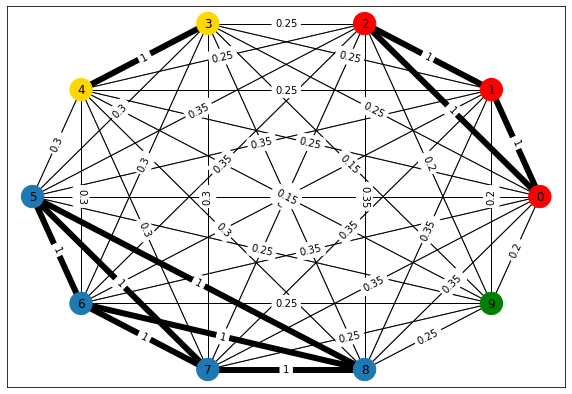

In [45]:
# Small toy data set

pop0 = [0, 1, 2]
pop1 = [3, 4]
pop2 = [5, 6, 7, 8]
pop3 = [9]
populations = [pop0, pop1, pop2, pop3]
weights = {(0,1): 0.25, (0, 2):0.35, (0, 3): 0.2, (1, 2): 0.3, (1, 3): 0.15, (2,3):0.25}

pop_graphs = [nx.complete_graph(pop) for pop in populations]
big_g = create_conglomerate_graph(pop_graphs, weights, 1)

time step 1


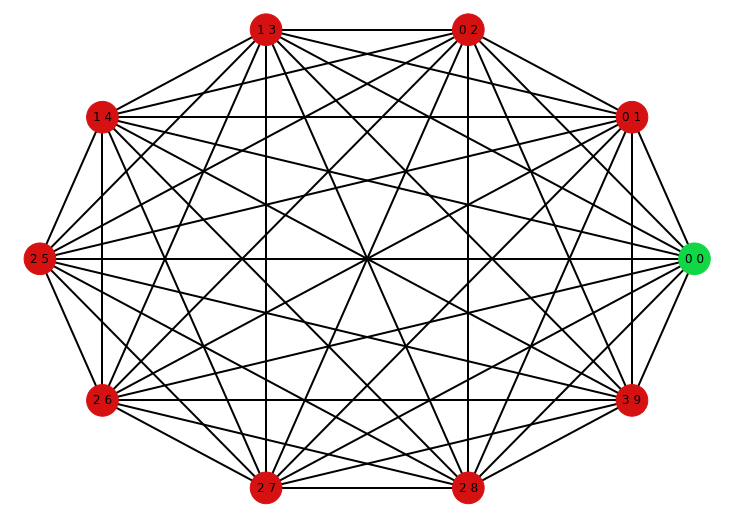

time step 2


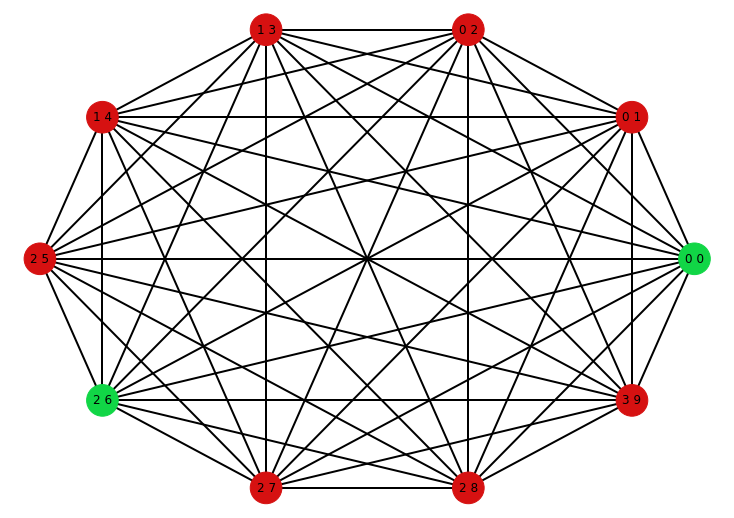

time step 3


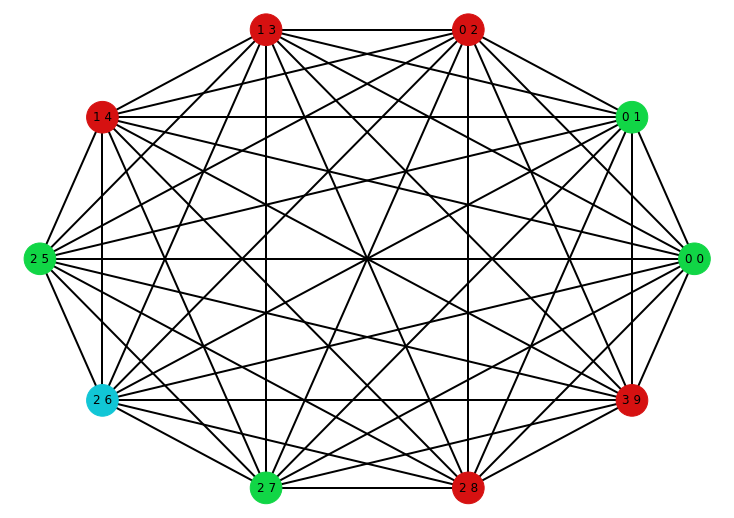

time step 4


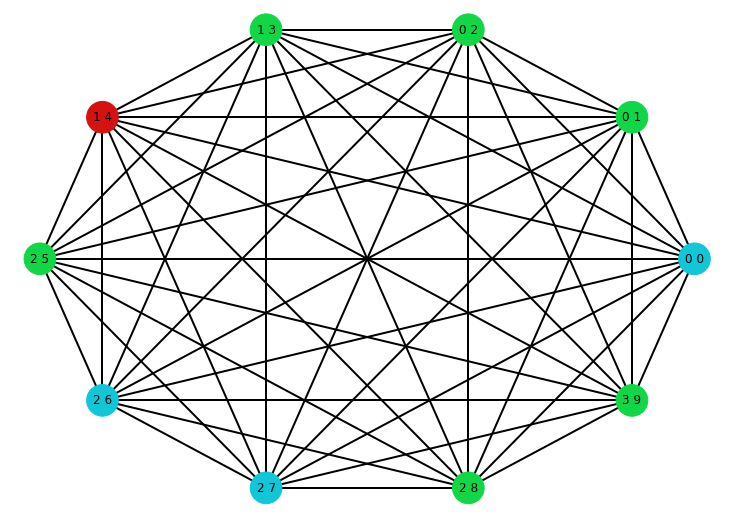

time step 5


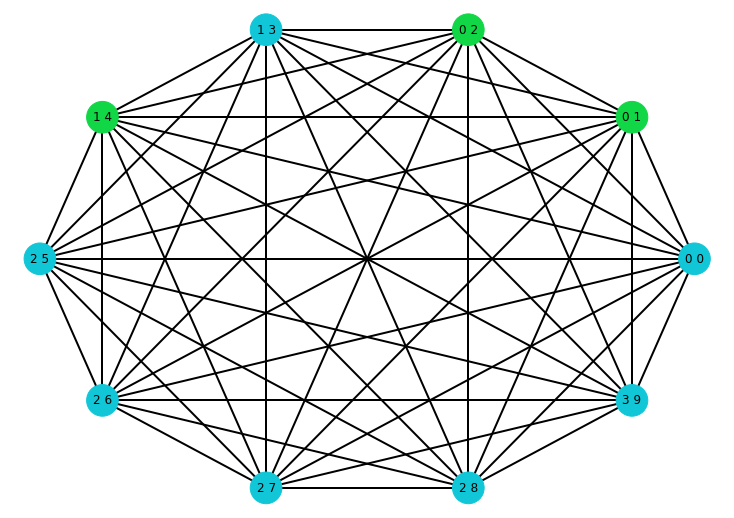

time step 6


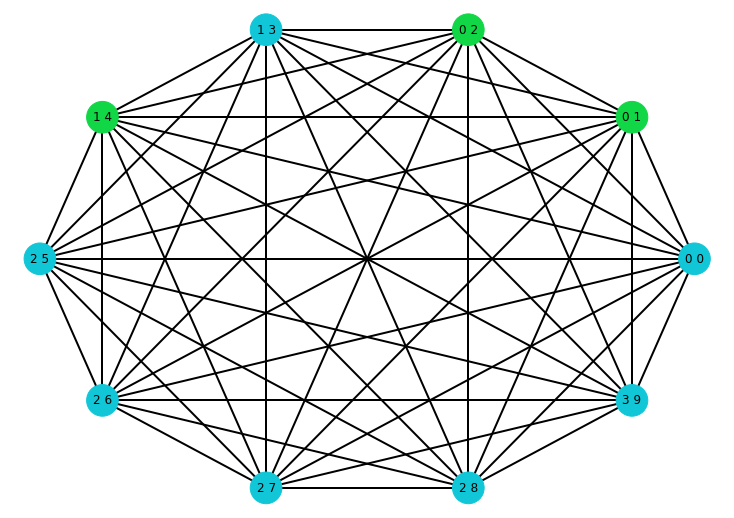

time step 7


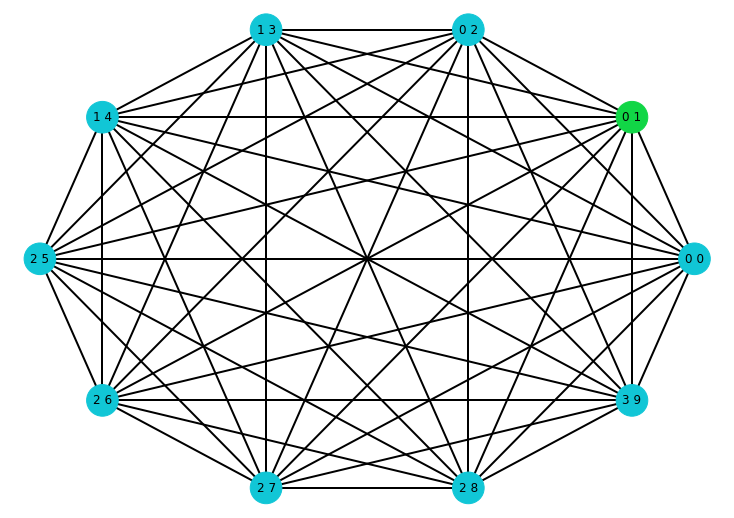

time step 8


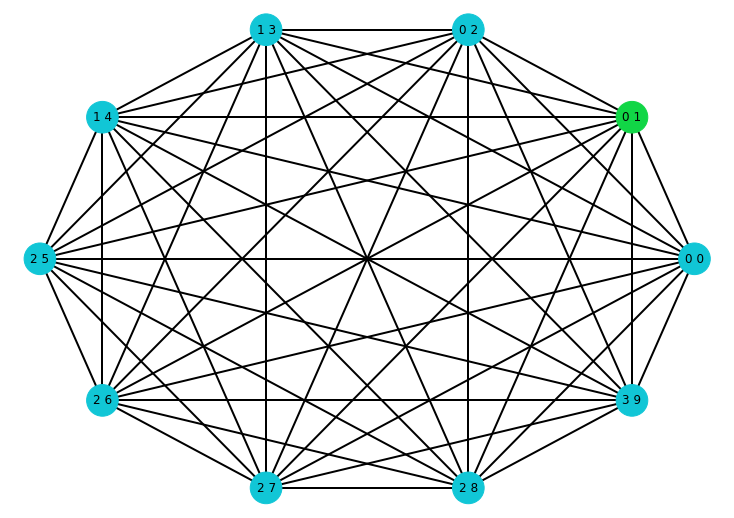

time step 9


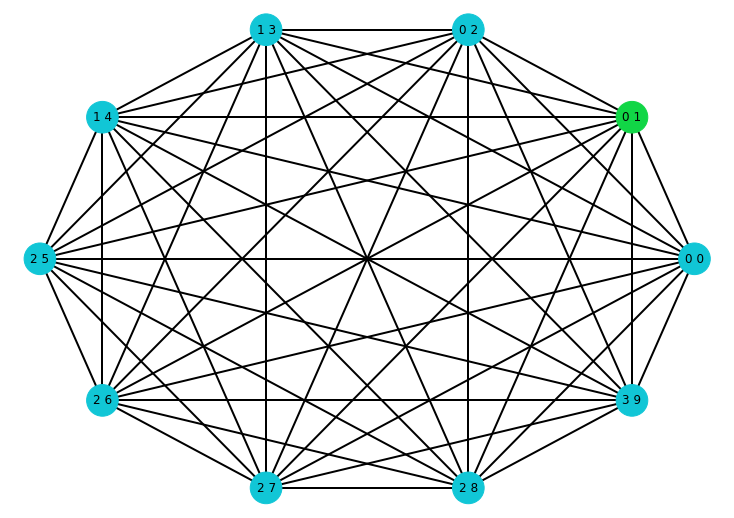

time step 10


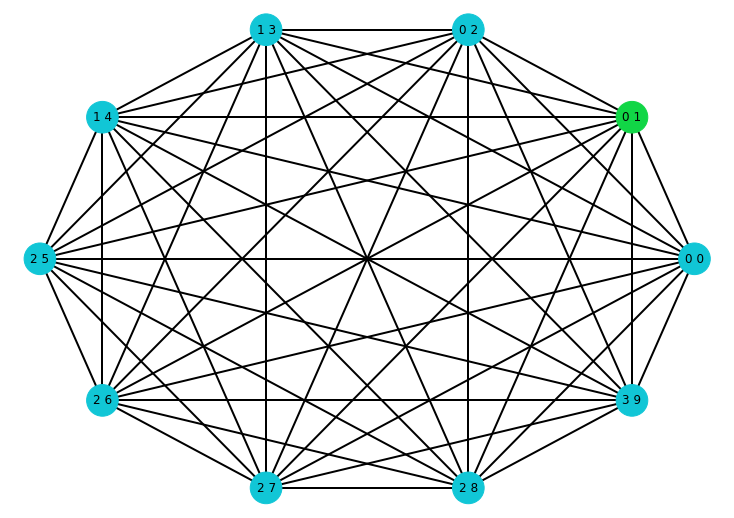

time step 11


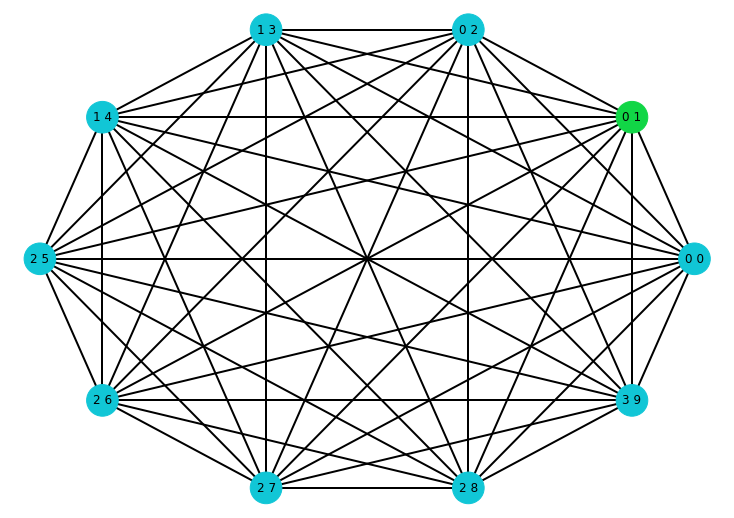

time step 12


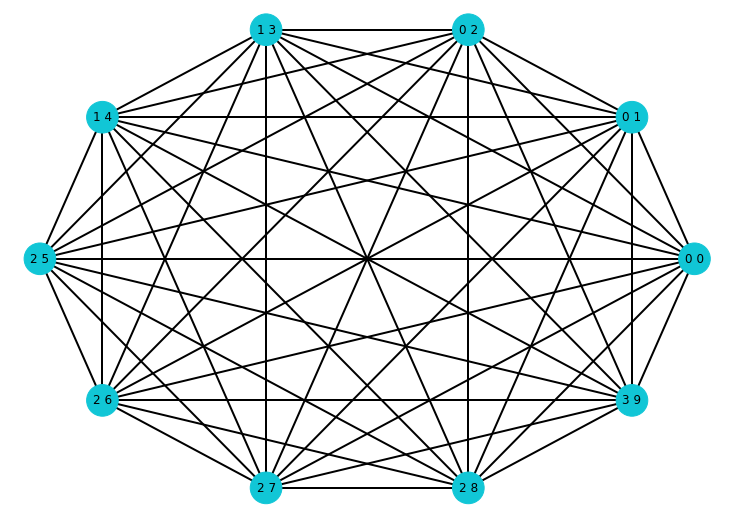

In [46]:
St_global,It_global,Rt_global,xt,St_pop,It_pop,Rt_pop= run_SIR_weighted(big_g,1,0.4,0.4,1)

In [47]:
# create actual population nodes
full_0 = list(range(60))
full_1 = list(range(60, 100))
full_2 = list(range(100, 180))
full_3 = list(range(180, 200))

In [48]:
full_pops = [full_0, full_1, full_2, full_3]
pop_graphs = [nx.complete_graph(pop) for pop in full_pops]

sir_g = create_conglomerate_graph(pop_graphs, weights, 0)

In [52]:
St_global,It_global,Rt_global,xt,St_pop,It_pop,Rt_pop = run_SIR_weighted(sir_g,1,0.4,0.4,0)

------------------------------ GLOBAL POPULATION ------------------------------


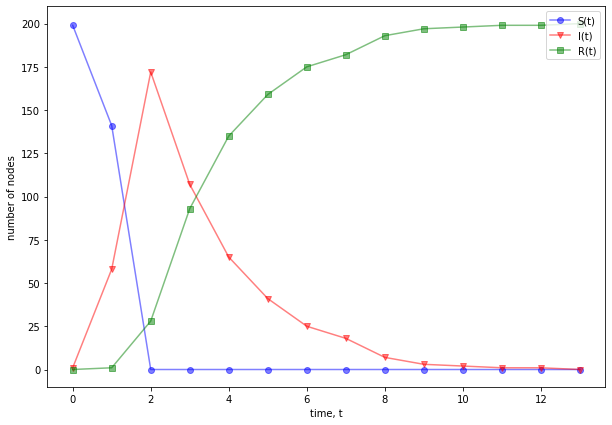

In [53]:
print('------------------------------ GLOBAL POPULATION ------------------------------')
plot_epidemicDynamics(St_global,It_global,Rt_global)

--------------------------------- POPULATION 1 ---------------------------------


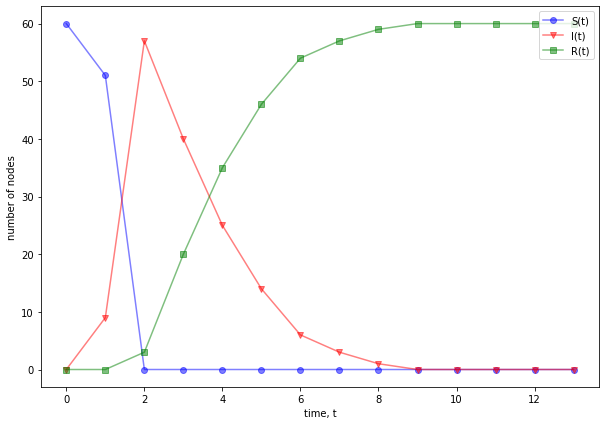

--------------------------------- POPULATION 2 ---------------------------------


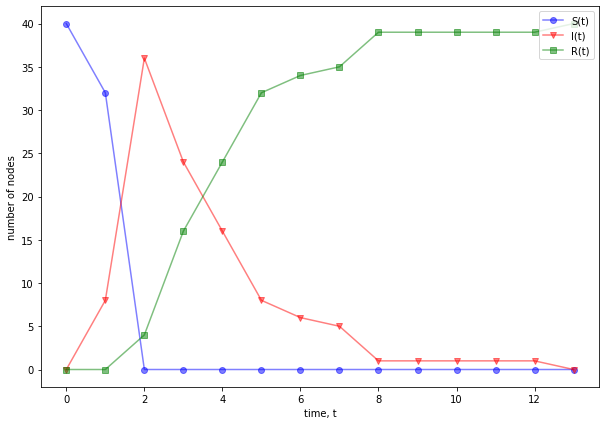

--------------------------------- POPULATION 3 ---------------------------------


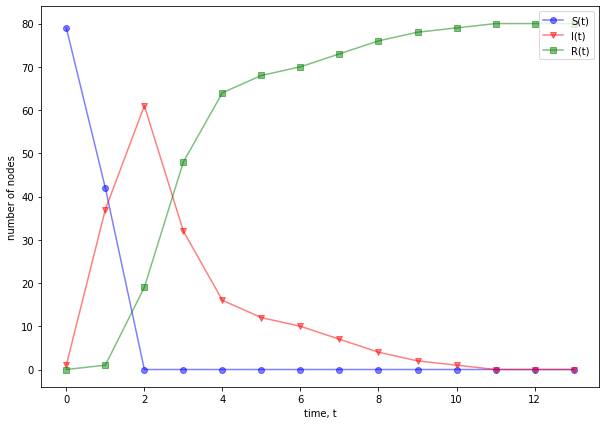

--------------------------------- POPULATION 4 ---------------------------------


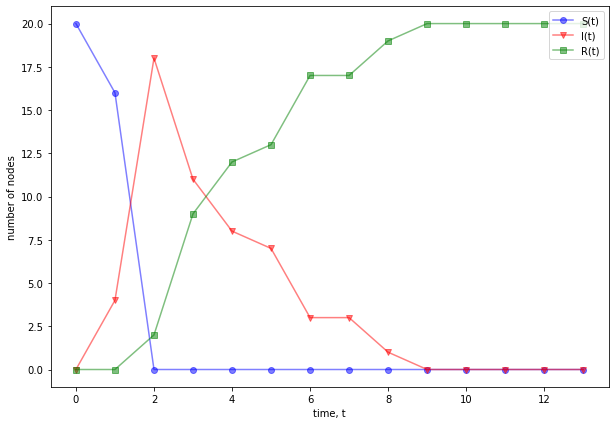

In [54]:
for i in range(len(St_pop)):
    print(f'--------------------------------- POPULATION {i + 1} ---------------------------------')
    plot_epidemicDynamics(St_pop[i],It_pop[i],Rt_pop[i])

In [34]:
def calc_mean_variance(lst):
    '''Calculates the mean and variance of a given list. 
    To create this function I researched how to calculate this online and used
    this website: https://www.geeksforgeeks.org/python-variance-of-list/'''
    mean = sum(lst) / len(lst)
    var = sum((i - mean) ** 2 for i in lst) / len(lst)
    return mean, var

In [35]:
# This function is from CSCI 3352 PS7 By Aaron Clauset

def drawFrom_SE(n,beta,lmbda):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws n values from a stretched exponential distribution with parameters beta,lambda
    # and then rounds them to integers for use as degrees. It returns these in a list x.

    xmin = 0.5  # minimum value 
    x    = [] # 
    for i in range(n):
        xi = int(round( (xmin**beta - (1/lmbda)*np.log(1-random.random()))**(1/beta) ))
        x.append(xi)

    return x

In [36]:
test_pop1 = drawFrom_SE(60, 1.5, 0.25)
calc_mean_variance(test_pop1)

(2.55, 2.3141666666666665)

In [37]:
test_pop2 = drawFrom_SE(40, 1, 0.5)
calc_mean_variance(test_pop2)

(2.55, 2.9975)

In [38]:
test_pop3 = drawFrom_SE(80, 1, 0.5)
calc_mean_variance(test_pop3)

(2.4625, 3.323593749999998)

In [39]:
test_pop4 = drawFrom_SE(20, 1, 0.5)
calc_mean_variance(test_pop4)

(3.15, 14.527499999999998)

In [40]:
# Use random graphs to create population interconnection graphs

random_populations = [test_pop1, test_pop2, test_pop3, test_pop4]
combos = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
random_weights = {c:random.random()/2 for c in combos}

population_random_graphs = [nx.expected_degree_graph(p) for p in random_populations]

mapping_p2 = {l: l + 60 for l in range(40)}
mapping_p3 = {l: l + 100 for l in range(80)}
mapping_p4 = {l: l + 180 for l in range(20)}

rand2 = nx.relabel_nodes(population_random_graphs[1], mapping_p2)
#print(rand2.nodes())
rand3 = nx.relabel_nodes(population_random_graphs[2], mapping_p3)
rand4 = nx.relabel_nodes(population_random_graphs[3], mapping_p4)

randoms = [population_random_graphs[0], rand2, rand3, rand4]

random_global = create_conglomerate_graph(randoms, random_weights, 0)

In [41]:
St_global,It_global,Rt_global,xt,St_pop,It_pop,Rt_pop = run_SIR_weighted(random_global,1,0.4,0.4,0)

------------------------------ GLOBAL POPULATION ------------------------------


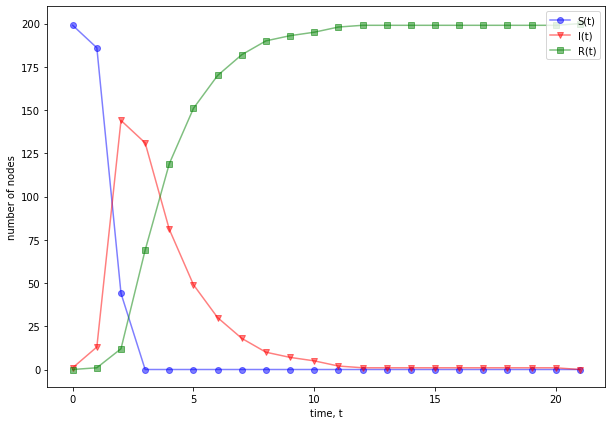

In [42]:
print('------------------------------ GLOBAL POPULATION ------------------------------')
plot_epidemicDynamics(St_global,It_global,Rt_global)

--------------------------------- POPULATION 1 ---------------------------------


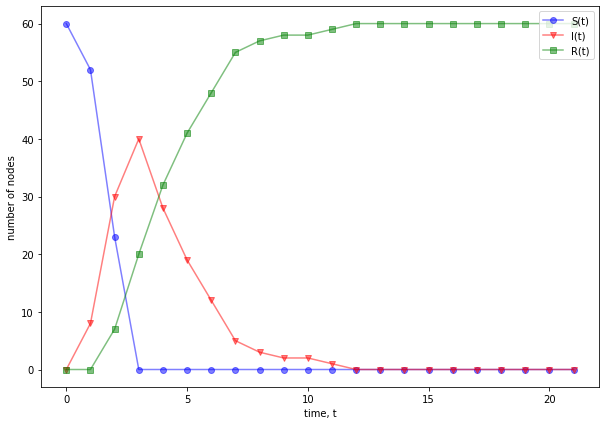

--------------------------------- POPULATION 2 ---------------------------------


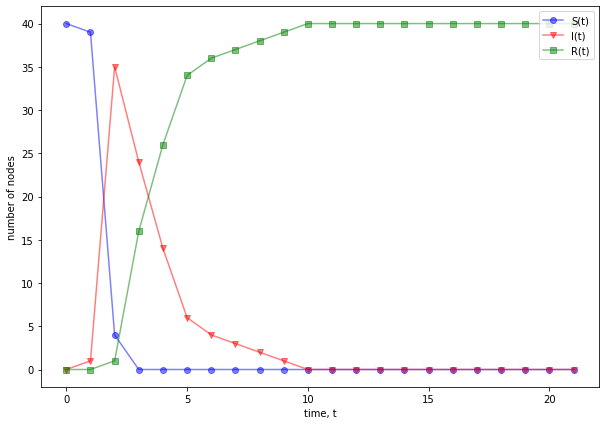

--------------------------------- POPULATION 3 ---------------------------------


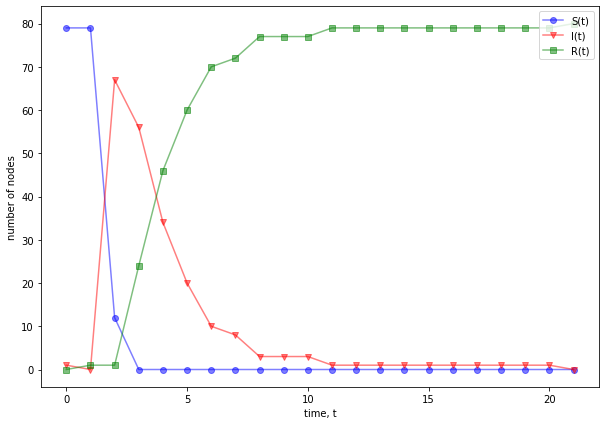

--------------------------------- POPULATION 4 ---------------------------------


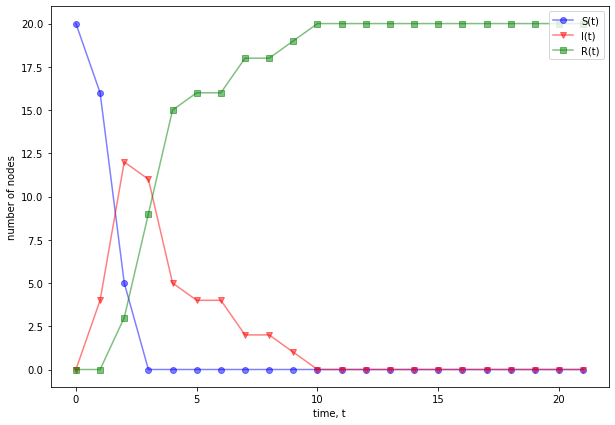

In [43]:
for i in range(len(St_pop)):
    print(f'--------------------------------- POPULATION {i + 1} ---------------------------------')
    plot_epidemicDynamics(St_pop[i],It_pop[i],Rt_pop[i])